In [1]:
#Import all necessary libraries
#------------------------------
import os
from os import listdir
from os.path import isfile, join
import plotly.io as pio
import plotly.express as px
import regex as re
import pandas as pd
from pandas import DataFrame
from pandas import to_datetime
import matplotlib 
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
#Open and append AE attendance data from excel files prior to April 2018
#-----------------------------------------------------------------------

path_excel = '/Users/mattiaficarelli/Documents/GitHub/nhsx/ae_attendances_modelling/raw_data/AE_admissions_data_prior_April_2018/'
file_header_list_excel = ['Code', 
'Region', 'Name', 
'Type 1 Departments - Major A&E', 
'Type 2 Departments - Single Specialty', 
'Type 3 Departments - Other A&E/Minor Injury Unit']

onlyexcelfiles = [f for f in listdir(path_excel) if isfile(join(path_excel, f))]
df_append_excel = pd.DataFrame()
regex_to_extract_date = re.compile(r'^([^.]*)-AE*') #--- regex to extract data from file name
for file in onlyexcelfiles:
    df = pd.read_excel(path_excel + file, names = file_header_list_excel, skiprows=17, usecols="B:G")
    date_from_filename = regex_to_extract_date.findall(file)
    df['Date']= date_from_filename[0] #--- add date extracted from file name as a new column during appending
    df_append_excel = df_append_excel.append(df, ignore_index=True)

df_append_excel_clean_1 = df_append_excel[df_append_excel['Code'].notna()].reset_index(drop = True)
df_append_excel_clean_1['Date'] = pd.to_datetime(df_append_excel_clean_1['Date'])
df_append_excel_clean_2 = df_append_excel_clean_1.rename(columns = {'Code': 'ODS code', 'Name': 'Organisation name', 
'Type 1 Departments - Major A&E': 'Type 1', 
'Type 2 Departments - Single Specialty': 'Type 2', 
'Type 3 Departments - Other A&E/Minor Injury Unit': 'Other'})
df_append_excel_clean_3 = df_append_excel_clean_2[["Date", "ODS code", "Organisation name", "Type 1", "Type 2", "Other"]]
df_append_excel_clean_3["Total A&E attendences"] = df_append_excel_clean_3["Type 1"] + df_append_excel_clean_3["Type 2"] + df_append_excel_clean_3["Other"]
df_append_excel_clean_4 = df_append_excel_clean_3.sort_values(by=['Date']).reset_index(drop = True)

In [3]:
#Open and append AE attendance data from excel files from April 2018
#-------------------------------------------------------------------

path = '/Users/mattiaficarelli/Documents/GitHub/nhsx/ae_attendances_modelling/raw_data/AE_admissions_data/'
file_header_list = ['Period',
'Org Code', 
'Parent Org', 
'Org name', 
'A&E attendances Type 1', 
'A&E attendances Type 2', 
'A&E attendances Other A&E Department',
'A&E attendances Booked Appointments Type 1',
'A&E attendances Booked Appointments Type 2',
'A&E attendances Booked Appointments Other Department',
'Attendances over 4hrs Type 1',
'Attendances over 4hrs Type 2',
'Attendances over 4hrs Other Department',
'Attendances over 4hrs Booked Appointments Type 1',
'Attendances over 4hrs Booked Appointments Type 2',
'Attendances over 4hrs Booked Appointments Other Department',
'Patients who have waited 4-12 hs from DTA to admission',
'Patients who have waited 12+ hrs from DTA to admission',
'Emergency admissions via A&E - Type 1',
'Emergency admissions via A&E - Type 2',
'Emergency admissions via A&E - Other A&E department',
'Other emergency admissions']

onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
df_append = pd.DataFrame()
for file in onlyfiles:
    df = pd.read_csv(path + file, names = file_header_list, skiprows=1)
    df_append = df_append.append(df, ignore_index=True)

df_clean_1 = df_append[df_append["Period"].str.contains("TOTAL")==False].reset_index(drop = True)
df_clean_1['Period'] = pd.to_datetime(df_clean_1['Period'].str.replace("MSitAE-", "")) #----- remove string from Date column
df_clean_2 = df_clean_1.sort_values(by=['Period']).reset_index(drop = True)
df_clean_3 = df_clean_2[["Period", "Org Code","Org name", "A&E attendances Type 1","A&E attendances Type 2", 'A&E attendances Other A&E Department']]
df_clean_4 = df_clean_3.rename(columns = {'Period': 'Date', 'Org Code': 'ODS code', 'Org name': 'Organisation name', 'A&E attendances Type 1': 'Type 1', 'A&E attendances Type 2': 'Type 2', 'A&E attendances Other A&E Department': 'Other'})
df_clean_4["Total A&E attendences"] = df_clean_4["Type 1"] + df_clean_4["Type 2"] + df_clean_4["Other"]

In [4]:
#Join all AE attendance data into a single cleaned datafile
#-------------------------------------------------------------------

df_final = df_append_excel_clean_4.append(df_clean_4)
df_final_1 = df_final.drop(["ODS code", "Organisation name"], axis=1)
df_final.to_csv('data/final_cleaned_data.csv')

In [5]:
#Join group cleaned data by date 
#-------------------------------------------------------------------

df_final_group = df_final_1.groupby("Date").sum().reset_index()

In [6]:
#Visualise AE attendance data as a stacked bar chart using plotly
#-------------------------------------------------------------------

pd.options.plotting.backend = "plotly"
fig = px.bar(df_final_group, x='Date', y= ["Type 1", "Type 2","Other"],
color_discrete_sequence=["#003087", "#0072CE", "#41B6E6"],
labels={"value": "Number of A&E attendances", "variable": "A&E attendances"})
fig.update_layout(
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"},
    font = dict(family = "Arial", size = 16),
    autosize=True,
    margin=dict(l=50, r=50, b=50, t=50, pad=4, autoexpand=True),
)
fig.show()

#Save generated graph as a .png into local repo
#-------------------------------------------------------------------

pio.write_image(fig, 'images/visualization_type_ae_attendance.png', format= "png", scale=1, width=1500, height=700)

In [7]:
#Pepare cleaned data for prophet
#-------------------------------------------------------------------

mask = (df_final_group['Date'] <= '2019-12-01') #----- Filter data to remove all data points after 2019-12 (select only precovid data)
df_final_precovid = df_final_group.loc[mask]
df_precvoid_prophet = df_final_precovid[['Date', 'Total A&E attendences']]
df_precvoid_prophet_1 = df_precvoid_prophet.rename(columns = {'Date': 'ds', 'Total A&E attendences': 'y' })

In [15]:
df_precvoid_prophet.to_csv("data/historical_actual.csv")

In [8]:
#Intialise prophet model
#-------------------------------------------------------------------
model = Prophet()
model.fit(df_precvoid_prophet_1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 4500x3500 with 0 Axes>

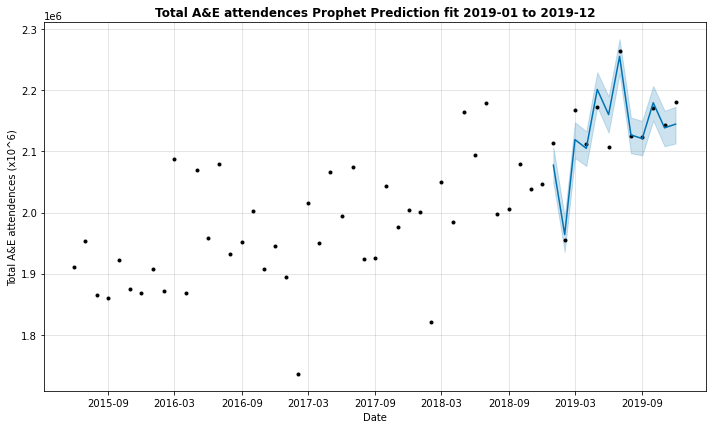

In [9]:
# Check accuracy of model by aligning it to 12 months of data (2019-01 to 2019-12)
#---------------------------------------------------------------------------------

historical_check = list()
for i in range(1, 13):
	date = '2019-%01d-01' % i
	historical_check.append([date])
historical_check = DataFrame(historical_check)
historical_check.columns = ['ds']
historical_check['ds']= to_datetime(historical_check['ds'])
historical_check_forecast = model.predict(historical_check)


# summarize the historical check forecast in a df
#-------------------------------------------------

historical_forecast = pd.DataFrame(historical_check_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

#Format and plot graphical output of model
#------------------------------------------

figure(figsize = (18, 14), dpi = 250)
model.plot(historical_check_forecast)
matplotlib.pyplot.xlabel("Date")
matplotlib.pyplot.ylabel("Total A&E attendences (x10^6)")
plt.title("Total A&E attendences Prophet Prediction fit 2019-01 to 2019-12", fontweight ="bold")
pyplot.show()
plt.rcParams.update({'font.size': 16})

<Figure size 4500x3500 with 0 Axes>

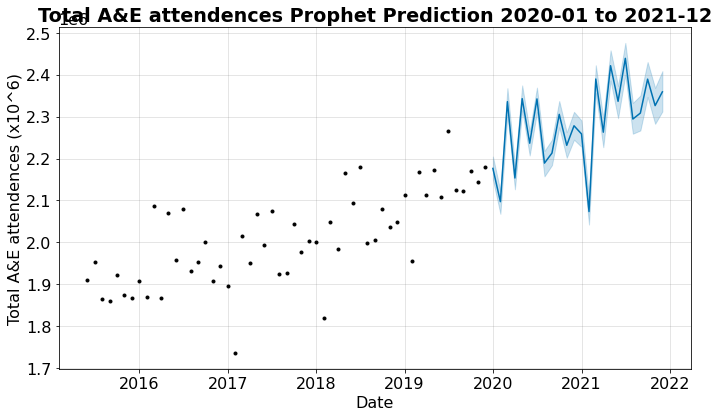

In [10]:
# Use model to predict 24 months of data (2020-01 to 2021-12)
#---------------------------------------------------------------------------------

future = list()
for i in range(1, 13):
	date = '2020-%01d' % i
	future.append([date])
for i in range(1, 13):
  date = '2021-%01d' % i
  future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast = model.predict(future)

# summarize the 24 month predicted forecast in a df
#-------------------------------------------------

future_forecast = pd.DataFrame(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


#Format and plot graphical output of future forecast
#---------------------------------------------------

figure(figsize = (18, 14), dpi = 250)
model.plot(forecast)
matplotlib.pyplot.xlabel("Date")
matplotlib.pyplot.ylabel("Total A&E attendences (x10^6)")
plt.title("Total A&E attendences Prophet Prediction 2020-01 to 2021-12", fontweight ="bold")
pyplot.show()
plt.rcParams.update({'font.size': 16})


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


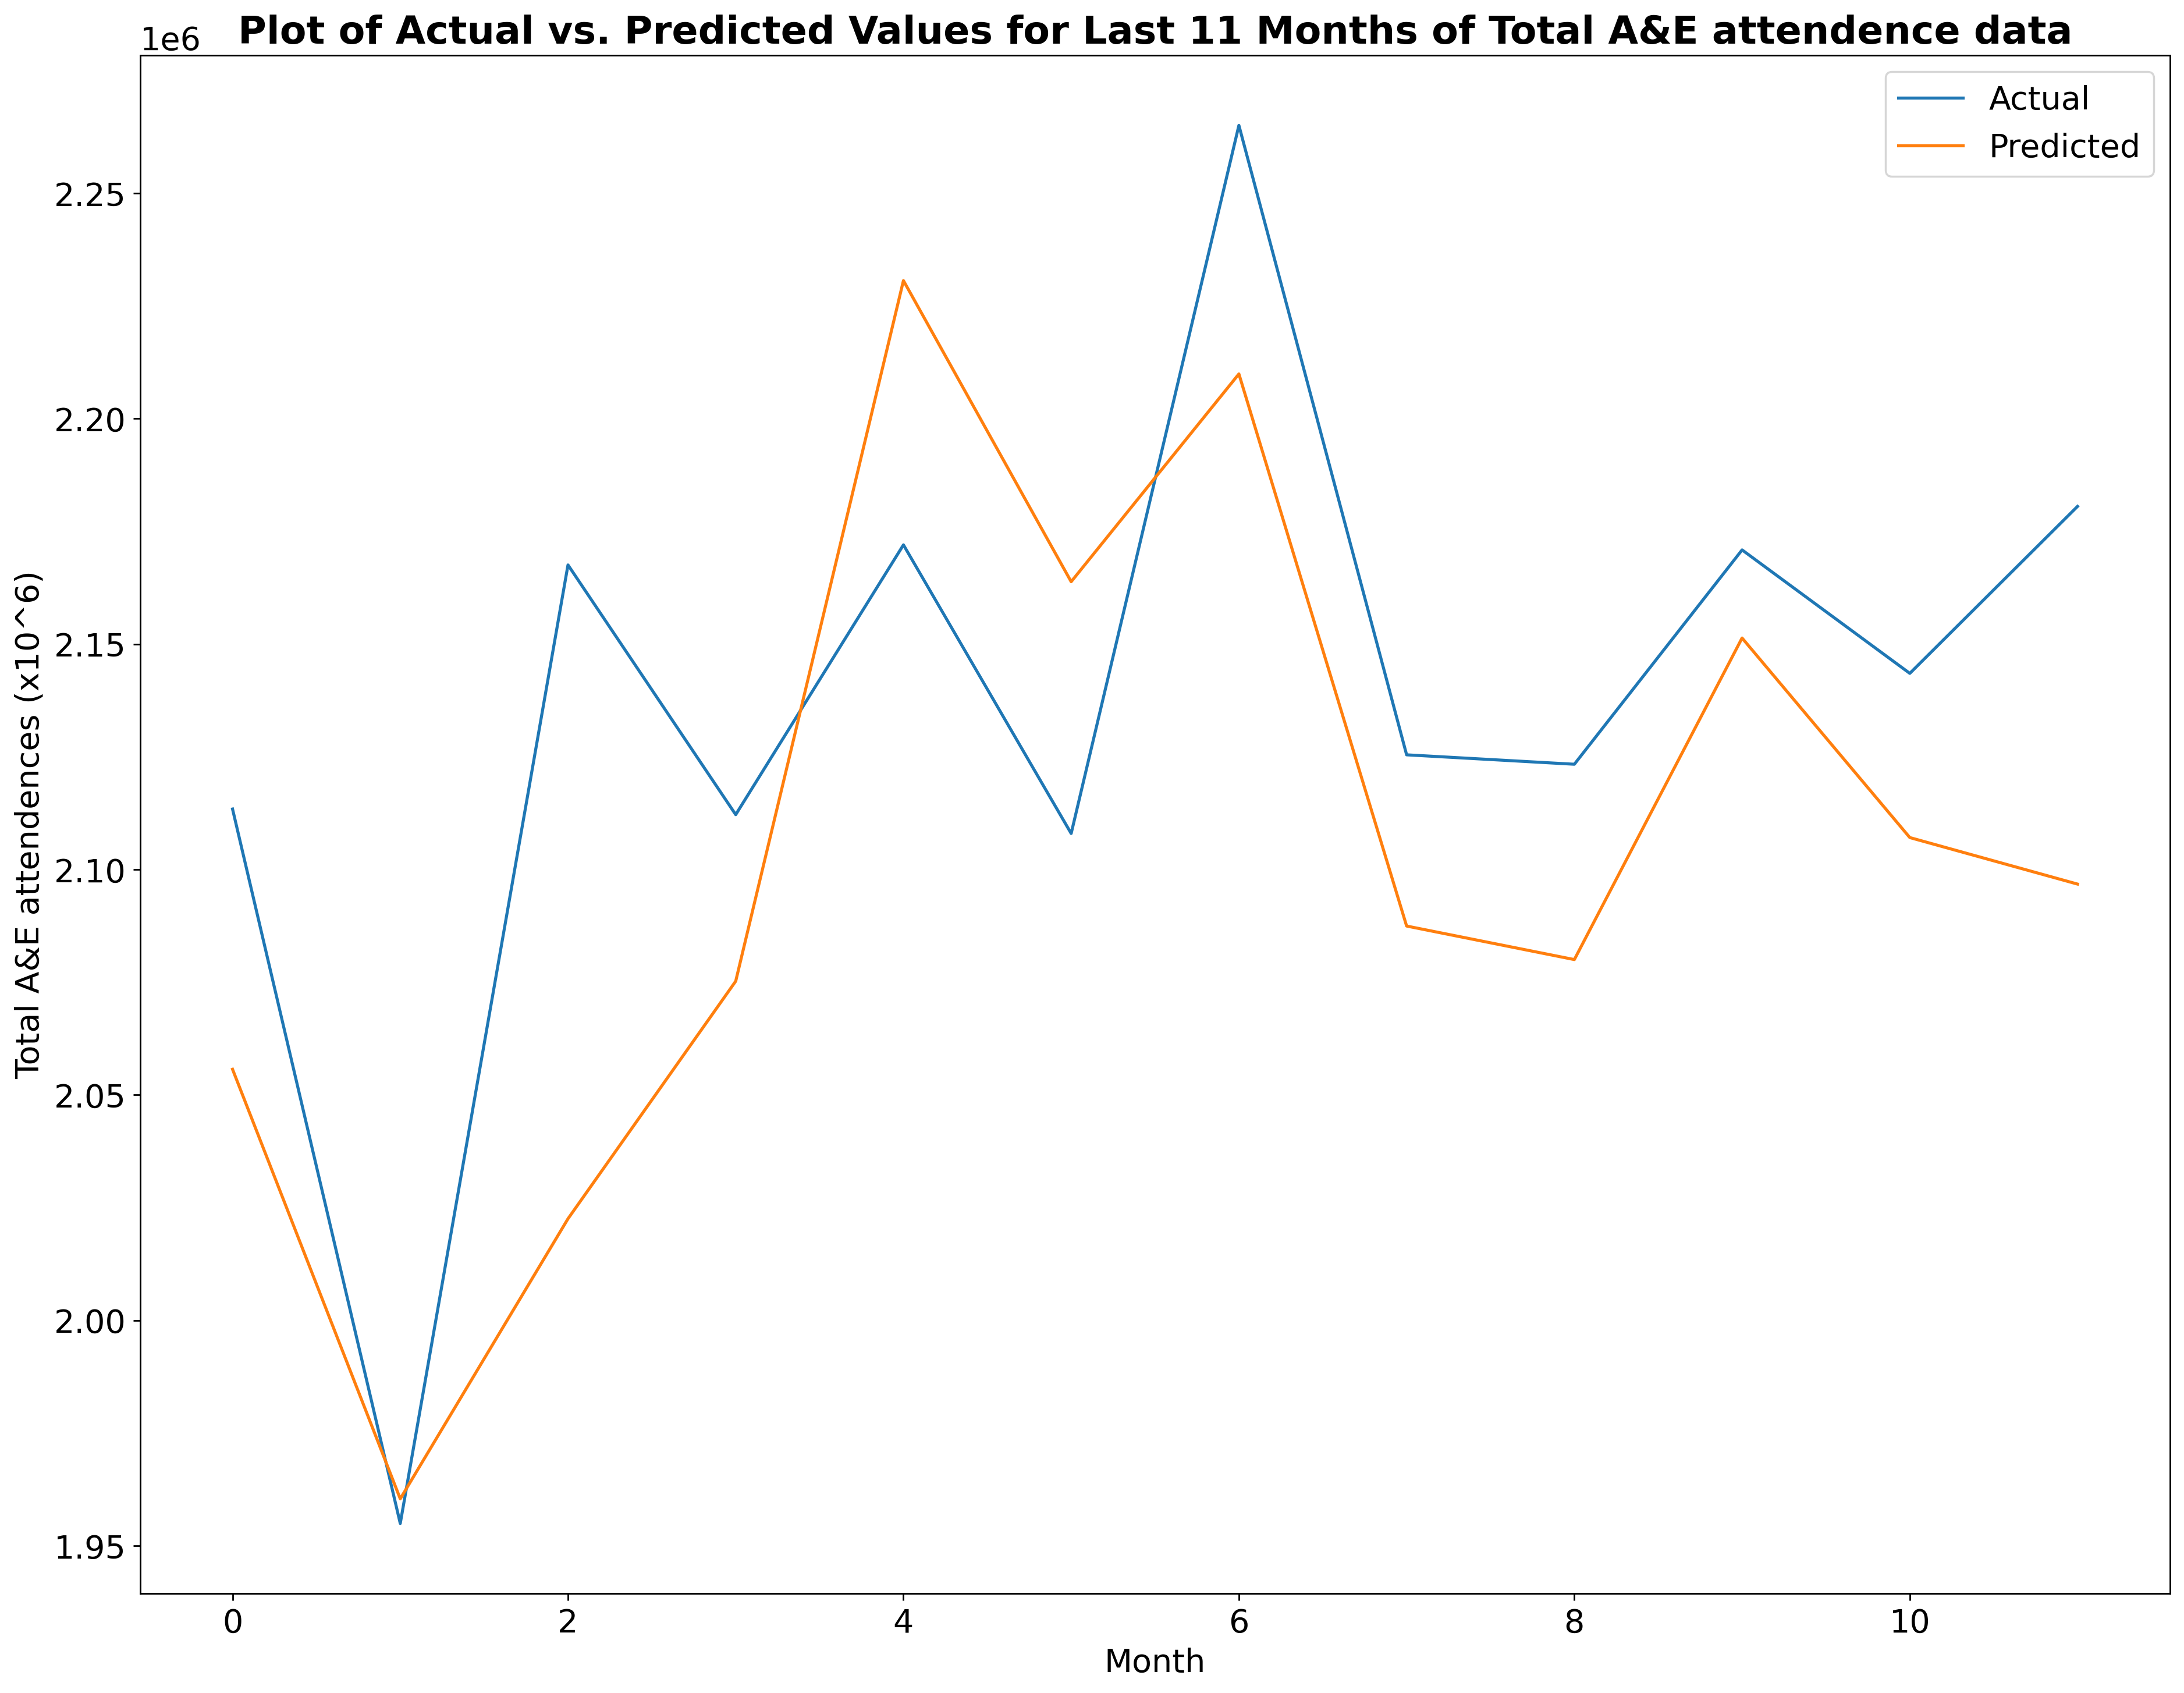

In [11]:
# Use manually evalute forecast model by retaining last 12 months of data
#---------------------------------------------------------------------------------

train = df_precvoid_prophet_1.drop(df_precvoid_prophet_1.index[-12:])

# Define and fit the model to data (with last 12 months hidden from it)
#---------------------------------------------------------------------------------
model = Prophet()
model.fit(train)

# Define and fit the model to data (with last 12 months hidden from it)
#---------------------------------------------------------------------------------

future = list()
for i in range(1, 13):
	date = '2019-%01d-01' % i
	future.append([date])
future = DataFrame(future)
future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])

# use the model to make a forecast
forecast = model.predict(future)

# calculate MAE between expected and predicted values for december
y_true = df_precvoid_prophet_1['y'][-12:].values
y_pred = forecast['yhat'].values

# plot expected vs actual
#---------------------------------------------------------------------------------

figure(figsize = (18, 14), dpi = 250)
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
matplotlib.pyplot.xlabel("Month")
matplotlib.pyplot.ylabel("Total A&E attendences (x10^6)")
plt.title("Plot of Actual vs. Predicted Values for Last 11 Months of Total A&E attendence data", fontweight ="bold")
pyplot.legend()
pyplot.show()
plt.rcParams.update({'font.size': 16})

In [12]:
#Calculate the mean absolute error and mean absolute percentage error of model
#---------------------------------------------------------------------------------
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

In [13]:
#Join predicted data from 2020-01 to 2021-12 to actual data
#-----------------------------------------------------------

df_final_group_1 = df_final_group[["Date", "Total A&E attendences"]]
df_final_group_1["Date"] = pd.to_datetime(df_final_group_1['Date'])
predicted_actual_join = pd.merge(
    future_forecast,
    df_final_group_1,
    left_on= "ds",
    right_on= "Date")

#Calculate % difference between actual and predicted data
#-----------------------------------------------------------
predicted_actual_join_1 = predicted_actual_join[['Date', 'Total A&E attendences', 'yhat']]
predicted_actual_join_2 = predicted_actual_join_1.rename(columns = {'yhat': 'Predicted A&E attendences', 
"Actual Total A&E attendences":'Total A&E attendences'})
predicted_actual_join_2["Absolute difference"] = (predicted_actual_join_2["Total A&E attendences"] - 
predicted_actual_join_2["Predicted A&E attendences"])
predicted_actual_join_2["Percent difference between predicted and actual A&E attendences"] = (predicted_actual_join_2["Absolute difference"]/
predicted_actual_join_2["Predicted A&E attendences"])*100

#Save cleaned actual vs. predicted data
#-----------------------------------------------------------

predicted_actual_join_2.to_csv("data/predicted_actual.csv")

<ipython-input-13-76dad9ed89e3>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
#Visualise % difference between actual and predicted data
#-----------------------------------------------------------

pd.options.plotting.backend = "plotly"
fig_2 = px.bar(predicted_actual_join_2, x='Date', y= "Percent difference between predicted and actual A&E attendences", width=1300, height=700,
color_discrete_sequence=["#003087", "#0072CE", "#41B6E6"],
labels={"value": "Percent difference", "variable": ""})
fig_2.update_layout(
    {"plot_bgcolor": "rgba(0, 0, 0, 0)", "paper_bgcolor": "rgba(0, 0, 0, 0)"},
    font = dict(family = "Arial", size = 16),
    autosize=True,
    margin=dict(l=50, r=50, b=50, t=50, pad=4, autoexpand=True),
)
fig_2.show()

#Save generated graph as a .png into local repo
#-------------------------------------------------------------------
pio.write_image(fig_2, 'images/percent_difference_actual.png', format= "png", scale=1, width=1500, height=700)